## Libraries

In [1]:
import json
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import gc
import itertools

from PIL import Image
from functools import partial
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras import layers
from keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
import numpy as np
import json
import utils_nn_eval
import gc

from keras import backend as K

from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

## Load Images

### GAN Images

In [3]:
gan_benign = utils_nn_eval.get_all_images('gan_benign')
gan_malignant = utils_nn_eval.get_all_images('gan_malignant')

In [4]:
print(len(gan_benign))
print(len(gan_malignant))

2000
2000


### Ground Truth Images

In [5]:
gt_benign = utils_nn_eval.get_all_images('gt_benign')
gt_malignant = utils_nn_eval.get_all_images('gt_malignant')

In [6]:
print(len(gt_benign))
print(len(gt_malignant))

625
1370


## Create Split

In [7]:
gan_X_test, gan_Y_test, gan_x_train, gan_x_val, gan_y_train, gan_y_val = utils_nn_eval.create_split(gan_benign, gan_malignant)

In [8]:
gt_X_test, gt_Y_test, gt_x_train, gt_x_val, gt_y_train, gt_y_val = utils_nn_eval.create_split(gt_benign, gt_malignant)

## Display Images

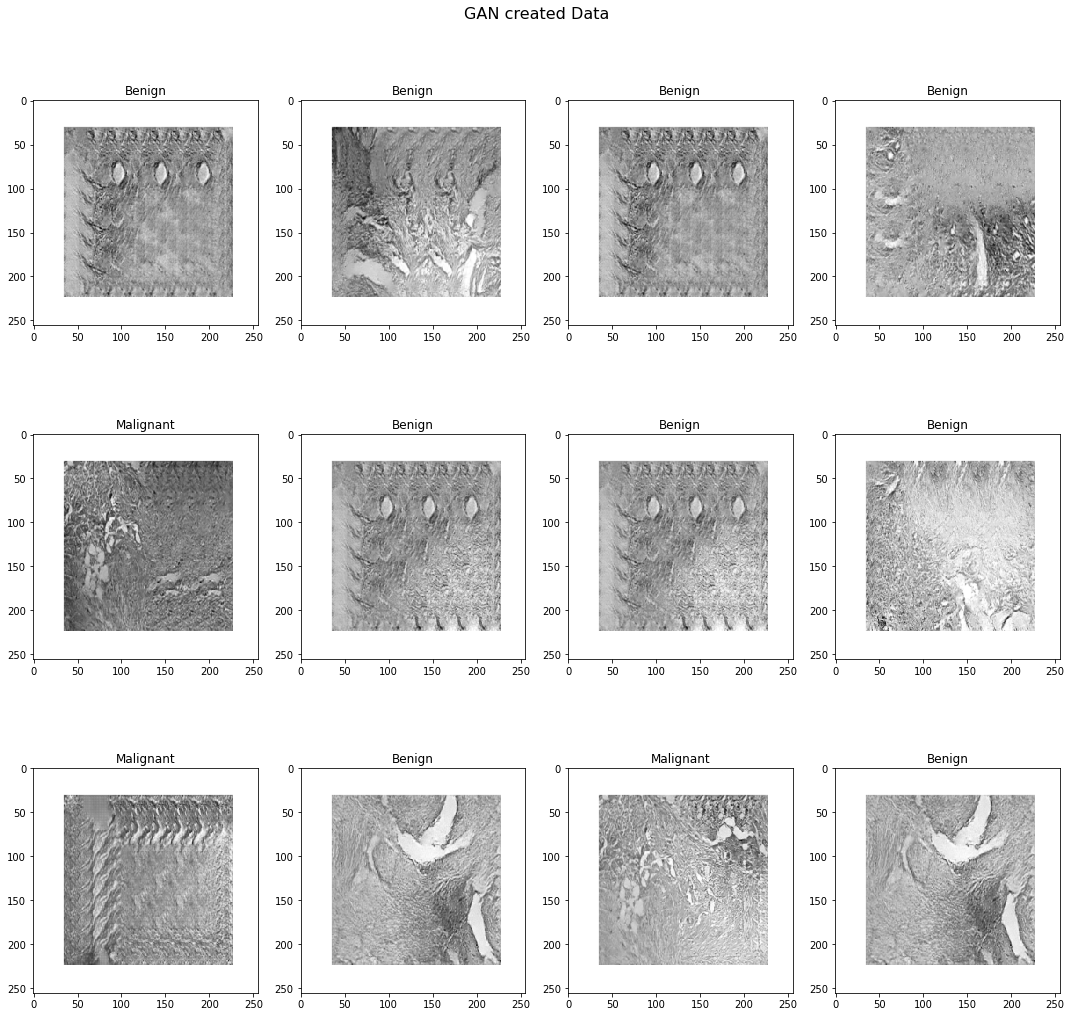

In [9]:
utils_nn_eval.display_images(gan_x_train, gan_y_train, "GAN created Data")

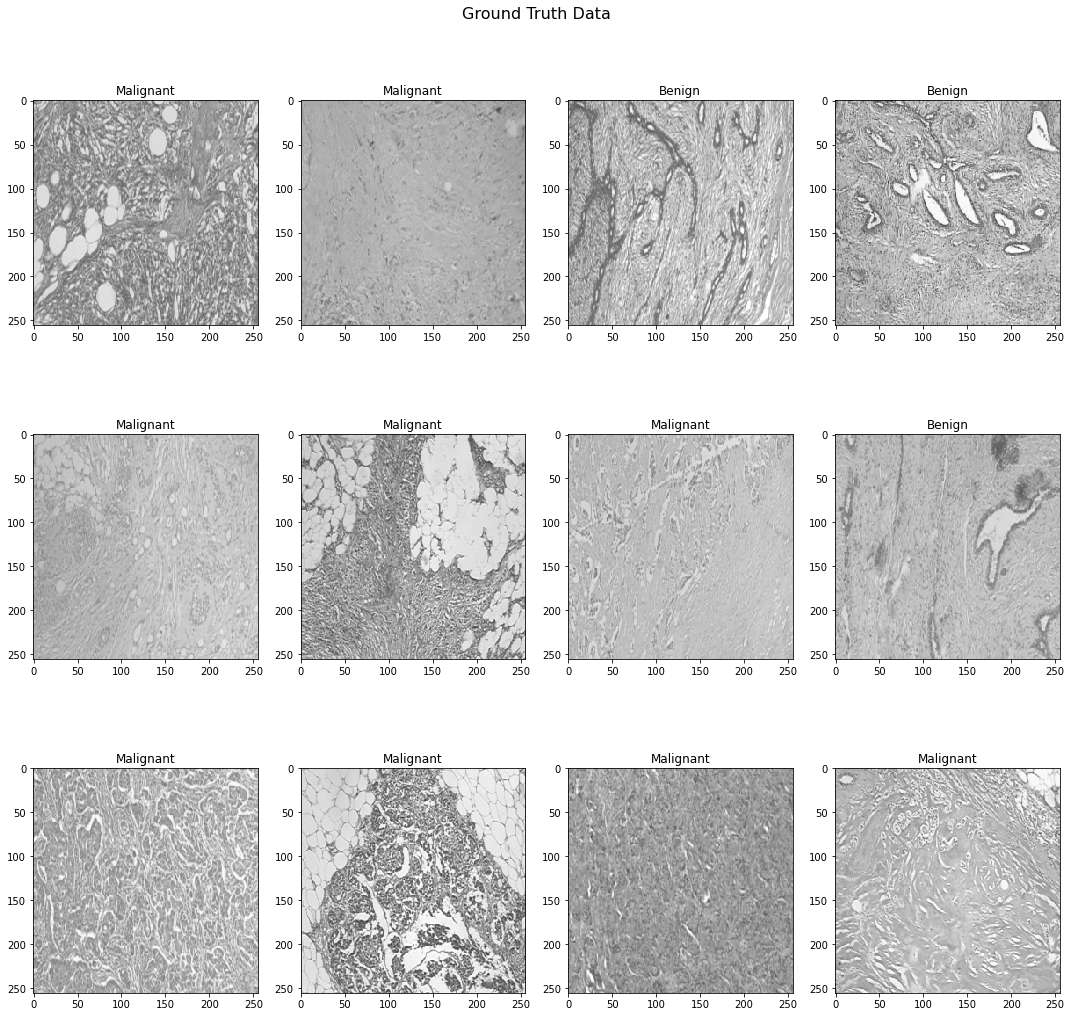

In [10]:
utils_nn_eval.display_images(gt_x_train, gt_y_train, "Ground Truth Data")

## Data Generator

In [11]:
train_generator = utils_nn_eval.create_train_generator()

## Model Creation

In [12]:
K.clear_session()
gc.collect()

model_densenet = utils_nn_eval.get_model("DenseNet", 256, 3)
# model_resnet = get_model("ResNet", 256, 3)
    
model_gt_gan = utils_nn_eval.build_model(model_densenet , lr = 1e-4)
model_gt_gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [13]:
# Learning Rate Reducer
learn_control = utils_nn_eval.learning_rate_reducer()

filepath_gt_gan = "D:/Medical_Imaging_Zusatz/Models/densenet_gt_train.hdf5"
checkpoint_gt_gan = utils_nn_eval.model_checkpoint(filepath_gt_gan)

## Training and Evaluation GAN Images

In [14]:
gt_history = utils_nn_eval.train_model(model_gt_gan, train_generator, gt_x_train, gt_y_train, gt_x_val, gt_y_val, learn_control, checkpoint_gt_gan)

Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.6437
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to D:/Medical_Imaging_Zusatz/Models\densenet_gt_train.hdf5
79/79 [==============================] - 639s 8s/step - loss: 0.6711 - accuracy: 0.6437 - val_loss: 0.7232 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7635
Epoch 2: val_accuracy did not improve from 0.56250
79/79 [==============================] - 647s 8s/step - loss: 0.5382 - accuracy: 0.7635 - val_loss: 1.2462 - val_accuracy: 0.4031 - lr: 1.0000e-04
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.7865
Epoch 3: val_accuracy improved from 0.56250 to 0.83750, saving model to D:/Medical_Imaging_Zusatz/Models\densenet_gt_train.hdf5
79/79 [==============================] - 707s 9s/step - loss: 0.4736 - accuracy: 0.7865 - val_loss: 0.4120 - val_accuracy: 

In [15]:
with open('gan_history.json', 'w') as f:
    
    json.dump(str(gt_history.history), f)

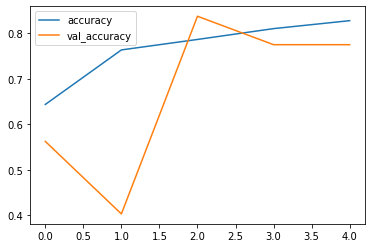

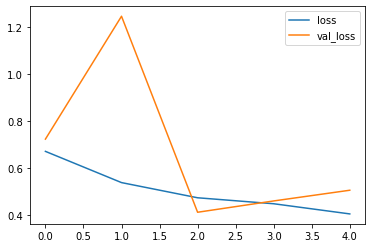

In [16]:
utils_nn_eval.plot_metrics(gt_history)

## Prediction on Ground Truth Data

In [17]:
model_gt_gan.load_weights(filepath_gt_gan)

In [18]:
Y_val_pred = model_gt_gan.predict(gt_x_val)

10/10 [==============================] - 36s 3s/step


In [19]:
accuracy_score(np.argmax(gt_y_val, axis=1), np.argmax(Y_val_pred, axis = 1))

0.8375

In [20]:
Y_pred = model_gt_gan.predict(gan_X_test)

25/25 [==============================] - 82s 3s/step


In [21]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):

    preds = model_gt_gan.predict_generator(train_generator.flow(gan_X_test, batch_size = 16, shuffle = False),
                                            steps = len(gan_X_test)/16)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis = 0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\elias\AppData\Local\Temp/ipykernel_43136/256335499.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model_gt_gan.predict_generator(train_generator.flow(gan_X_test, batch_size = 16, shuffle = False),
100%|██████████| 10/10 [12:14<00:00, 73.41s/it]


## Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 40 360]
 [320  80]]


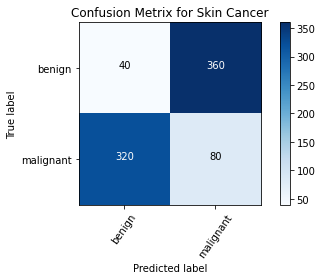

In [23]:
cm = confusion_matrix(np.argmax(gan_Y_test, axis = 1), np.argmax(Y_pred, axis = 1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[135 265]
 [227 173]]


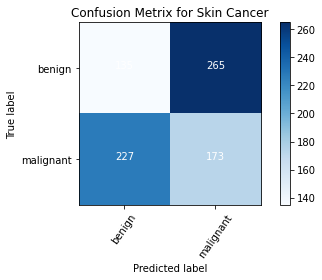

In [24]:
cm = confusion_matrix(np.argmax(gan_Y_test, axis = 1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

## Classification Report

In [25]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(gan_Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.37      0.34      0.35       400
           1       0.39      0.43      0.41       400

    accuracy                           0.38       800
   macro avg       0.38      0.39      0.38       800
weighted avg       0.38      0.39      0.38       800



## ROC and AUC

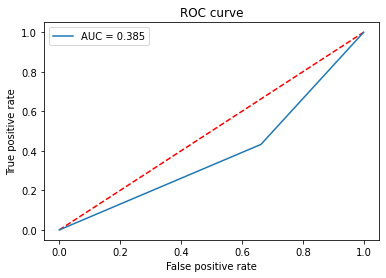

In [26]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(gan_Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(gan_Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

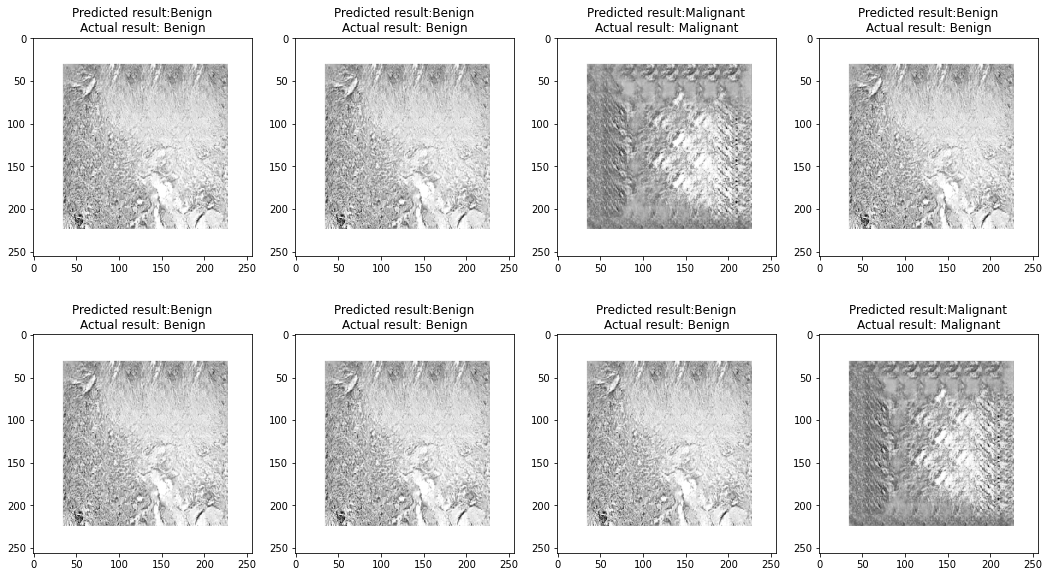

In [27]:
i = 0
prop_class=[]
mis_class=[]

for i in range(len(gan_Y_test)):

    if(np.argmax(gan_Y_test[i])==np.argmax(Y_pred_tta[i])):

        prop_class.append(i)

    if(len(prop_class)==8):

        break

i = 0

for i in range(len(gan_Y_test)):

    if(not np.argmax(gan_Y_test[i])==np.argmax(Y_pred_tta[i])):

        mis_class.append(i)

    if(len(mis_class)==8):

        break

# # Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize = (18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    
    if namecode==0:
    
        return "Benign"
    
    else:
    
        return "Malignant"
    
for i in range(len(prop_class)):
    
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(gan_Y_test[prop_class[i]])))
    plt.imshow(gan_X_test[prop_class[i]], interpolation='nearest')
    
plt.show()

## Backlog

In [ ]:
def get_all_images(path, cancer_type, resize_param):

    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert('L')) #'LA', 'L'

    for image in os.listdir(path + cancer_type):

        img = read(path + cancer_type + "/" + image)
        # img = cv2.imread(path + folder + "/" + image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize_param, resize_param))

        # täusche RGB Image an damit das fürs ResNet als input verwendet werden kann
        img = np.repeat(img[..., np.newaxis], 3, -1)

        images.append(np.array(img))

    return np.array(images)

In [ ]:
gan_benign_adenosis = get_all_images(gan_benign_path, "adenosis", image_size)
gan_benign_fibroadenoma = get_all_images(gan_benign_path, "fibroadenoma", image_size)
gan_benign_phyllodes_tumor = get_all_images(gan_benign_path, "phyllodes_tumor", image_size)
gan_benign_tubular_adenoma = get_all_images(gan_benign_path, "tubular_adenoma", image_size)

In [ ]:
gan_malignant_ductal_carcinoma = get_all_images(gan_malignant_path, "ductal_carcinoma", image_size)
gan_malignant_lobular_carcinoma = get_all_images(gan_malignant_path, "lobular_carcinoma", image_size)
gan_malignant_mucinous_carcinoma = get_all_images(gan_malignant_path, "mucinous_carcinoma", image_size)
gan_malignant_papillary_carcinoma = get_all_images(gan_malignant_path, "papillary_carcinoma", image_size)

NameError: name 'gan_malignant_' is not defined

In [ ]:
print(len(gan_benign_adenosis))
print(len(gan_benign_fibroadenoma))
print(len(gan_benign_phyllodes_tumor))
print(len(gan_benign_tubular_adenoma))

In [ ]:
print(len(gan_malignant_ductal_carcinoma))
print(len(gan_malignant_lobular_carcinoma))
print(len(gan_malignant_mucinous_carcinoma))
print(len(gan_malignant_papillary_carcinoma))

In [ ]:
# gt_benign_adenosis = get_all_images(gt_benign_path, "adenosis", image_size)
# gt_benign_fibroadenoma = get_all_images(gt_benign_path, "fibroadenoma", image_size)
# gt_benign_phyllodes_tumor = get_all_images(gt_benign_path, "phyllodes_tumor", image_size)
# gt_benign_tubular_adenoma = get_all_images(gt_benign_path, "tubular_adenoma", image_size)

In [ ]:
# gt_malignant_ductal_carcinoma = get_all_images(gt_malignant_path, "ductal_carcinoma", image_size)
# gt_malignant_lobular_carcinoma = get_all_images(gt_malignant_path, "lobular_carcinoma", image_size)
# gt_malignant_mucinous_carcinoma = get_all_images(gt_malignant_path, "mucinous_carcinoma", image_size)
# gt_malignant_papillary_carcinoma = get_all_images(gt_malignant_path, "papillary_carcinoma", image_size)

In [ ]:
# print(len(gt_benign_adenosis))
# print(len(gt_benign_fibroadenoma))
# print(len(gt_benign_phyllodes_tumor))
# print(len(gt_benign_tubular_adenoma))

In [ ]:
# print(len(gt_malignant_ductal_carcinoma))
# print(len(gt_malignant_lobular_carcinoma))
# print(len(gt_malignant_mucinous_carcinoma))
# print(len(gt_malignant_papillary_carcinoma))